In [1]:
import csv
from sklearn.model_selection import train_test_split
def data_processer(file_name : str, split : bool = False):
    feature, energy, latency = [], [], []
    with open(file_name, 'r') as fp:
        f_csv = csv.DictReader(fp)
        data = list(f_csv)
    for item in data:
        cin, cout = int(item['K']), int(item['N'])
        repeat = int(item['repeat'])
        feature.append([cin, cout])
        energy.append(float(item['energy']) / repeat)
        latency.append(float(item['latency']) / repeat)
    if split:
        feature_train, feature_test, energy_train, energy_test, latency_train, latency_test = train_test_split(feature, energy, latency)
        train_split = {
            'feature' : feature_train,
            'energy' : energy_train,
            'latency' : latency_train
        }
        test_split = {
            'feature' : feature_test,
            'energy' : energy_test,
            'latency' : latency_test
        }
        return train_split, test_split
    else:
        train_data = {
            'feature' : feature,
            'energy' : energy,
            'latency' : latency
        }
        return train_data

train_data, val_data = data_processer('onnx_gemm_results_resampled.csv', True)
test_data = data_processer('onnx_gemm_results_raw.csv', False)

In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error


def get_accuracy(y_pred, y_true, threshold = 0.01):
    a = (y_true - y_pred) / y_true
    b = np.where(abs(a) <= threshold)
    return len(b[0]) / len(y_true)


def get_metrics(y_pred, y_true):
    rmspe = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100
    rmse = np.sqrt(mean_squared_error(y_pred, y_true))
    error = rmse / np.mean(y_true)
    acc5 = get_accuracy(y_pred, y_true, threshold=0.05)
    acc10 = get_accuracy(y_pred, y_true, threshold=0.10)
    acc15 = get_accuracy(y_pred, y_true, threshold=0.15)
    print(f"rmse: {rmse:.4f}; rmspe: {rmspe:.4f}; error: {error:.4f}; 5% accuracy: {acc5:.4f}; 10% accuracy: {acc10:.4f}; 15% accuracy: {acc15:.4f}.")
    

In [3]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

for label in ["latency", "energy"]:
    model = RandomForestRegressor(
        max_depth=50,
        n_estimators=370,
        min_samples_leaf=1,
        min_samples_split=2,
        max_features=2,
        oob_score=True,
        random_state=10
    )
    model.fit(train_data["feature"], train_data[label])
    # val
    predicts = model.predict(val_data["feature"])
    print(f'{label} Results:')
    get_metrics(predicts, val_data[label])
    print("")
    # test
    predicts = model.predict(test_data["feature"])
    print('Testing set:')
    get_metrics(predicts, test_data[label])
    print("")
    


latency Results:
rmse: 0.0002; rmspe: 5.0565; error: 0.0326; 5% accuracy: 0.8593; 10% accuracy: 0.9550; 15% accuracy: 0.9863.

Testing set:
rmse: 0.0001; rmspe: 5.8415; error: 0.0149; 5% accuracy: 0.7667; 10% accuracy: 0.8667; 15% accuracy: 0.9333.

energy Results:
rmse: 0.0077; rmspe: 4.8006; error: 0.0309; 5% accuracy: 0.8714; 10% accuracy: 0.9646; 15% accuracy: 0.9831.

Testing set:
rmse: 0.0039; rmspe: 6.9418; error: 0.0200; 5% accuracy: 0.7667; 10% accuracy: 0.8667; 15% accuracy: 0.9000.



In [4]:
# seems svm regresser does not fit this situation
from sklearn.svm import SVR

for label in ["latency", "energy"]:
    svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
    svr_lin = SVR(kernel="linear", C=100, gamma="scale")
    svr_poly = SVR(kernel="poly", C=100, gamma="scale", degree=3, epsilon=0.1, coef0=1)
    print(f'{label} Results:')
    for model in [svr_rbf, svr_lin, svr_poly]:
        model.fit(train_data["feature"], train_data[label])
        predicts = model.predict(val_data["feature"])
        # print([(x, y) for x, y in zip(predicts, val_data[label])][:5])
        get_metrics(predicts, val_data[label])
    print("")


latency Results:
rmse: 0.0275; rmspe: 2270.7852; error: 5.0598; 5% accuracy: 0.0000; 10% accuracy: 0.0000; 15% accuracy: 0.0000.
rmse: 0.0275; rmspe: 2270.7852; error: 5.0598; 5% accuracy: 0.0000; 10% accuracy: 0.0000; 15% accuracy: 0.0000.
rmse: 0.0275; rmspe: 2270.7852; error: 5.0598; 5% accuracy: 0.0000; 10% accuracy: 0.0000; 15% accuracy: 0.0000.

energy Results:
rmse: 0.4398; rmspe: 425.7306; error: 1.7648; 5% accuracy: 0.0016; 10% accuracy: 0.0048; 15% accuracy: 0.0096.


In [ ]:
# Ridge Regression
from sklearn import linear_model

for label in ["latency", "energy"]:
    model = linear_model.Ridge(alpha=.5)
    model.fit(train_data["feature"], train_data[label])
    predicts = model.predict(val_data["feature"])
    print(f'{label} Results:')
    get_metrics(predicts, val_data[label])
    print("")
    


latency Results:
rmse: 0.0000; rmspe: 12.1379; error: 0.0819; 5% accuracy: 0.2581; 10% accuracy: 0.5161; 15% accuracy: 0.7742.

energy Results:
rmse: 0.0016; rmspe: 17.5204; error: 0.2603; 5% accuracy: 0.1935; 10% accuracy: 0.5484; 15% accuracy: 0.7097.



In [14]:
# Bayes Ridge Regression
from sklearn import linear_model

for label in ["latency", "energy"]:
    model = linear_model.BayesianRidge()
    model.fit(train_data["feature"], train_data[label])
    predicts = model.predict(val_data["feature"])
    print(f'{label} Results:')
    get_metrics(predicts, val_data[label])
    print("")

latency Results:
rmse: 0.0000; rmspe: 12.1379; error: 0.0819; 5% accuracy: 0.2581; 10% accuracy: 0.5161; 15% accuracy: 0.7742.

energy Results:
rmse: 0.0016; rmspe: 17.5208; error: 0.2604; 5% accuracy: 0.1935; 10% accuracy: 0.5484; 15% accuracy: 0.7097.



In [16]:
# SGD regressor does not work
from sklearn import linear_model

for label in ["latency", "energy"]:
    model = linear_model.SGDRegressor()
    model.fit(train_data["feature"], train_data[label])
    predicts = model.predict(val_data["feature"])
    print(f'{label} Results:')
    get_metrics(predicts, val_data[label])
    print("")

latency Results:
rmse: 4350721158818795.5000; rmspe: 5857916985507366043648.0000; error: 78090395369461530624.0000; 5% accuracy: 0.0000; 10% accuracy: 0.0000; 15% accuracy: 0.0000.

energy Results:
rmse: 18262103848741328.0000; rmspe: 161672714640362799104.0000; error: 2964022023167198720.0000; 5% accuracy: 0.0000; 10% accuracy: 0.0000; 15% accuracy: 0.0000.



In [17]:
# ElasticNet
from sklearn import linear_model

for label in ["latency", "energy"]:
    model = linear_model.ElasticNet()
    model.fit(train_data["feature"], train_data[label])
    predicts = model.predict(val_data["feature"])
    print(f'{label} Results:')
    get_metrics(predicts, val_data[label])
    print("")

latency Results:
rmse: 0.0001; rmspe: 42.2466; error: 1.5882; 5% accuracy: 0.0645; 10% accuracy: 0.1935; 15% accuracy: 0.1935.

energy Results:
rmse: 0.0089; rmspe: 20.6014; error: 1.4392; 5% accuracy: 0.3226; 10% accuracy: 0.4516; 15% accuracy: 0.6129.



In [ ]:
# GradientBoostingRegressor
from sklearn import ensemble

for label in ["latency", "energy"]:
    model = ensemble.GradientBoostingRegressor()
    model.fit(train_data["feature"], train_data[label])
    predicts = model.predict(val_data["feature"])
    print(f'{label} Results:')
    get_metrics(predicts, val_data[label])
    print("")

## Change Data Size to [Train 4000; Test 1000]

In [8]:
import json
from sklearn.model_selection import train_test_split
def data_processer(file_name):
    feature, engergy, latency = [], [], []
    with open(file_name, 'r') as fp:
        data = json.load(fp)
    for item in data:
        cin, cout = item["in_features"], item["out_features"]
        feature.append([cin, cout, cin * cout])
        engergy.append(item["energy"])
        latency.append(item["latency"])
    return (feature, latency)

data = data_processer("linear_results2.json")
X, Y = data
trainx, testx, trainy, testy = train_test_split(X, Y, test_size = 0.2, random_state = 10)


In [9]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor(
    max_depth=50,
    n_estimators=370,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=3,
    oob_score=True,
    random_state=10
)
model.fit(trainx, trainy)
predicts = model.predict(testx)

# locate large error data
errorx, errory = [], []
for i in range(len(testx)):
    y1, y2 = testy[i], predicts[i]
    # print(testy[i], predicts[i])
    error = abs(y1 - y2) / y1
    if error > 0.1:
        errorx.append(testx[i])
        errory.append(testy[i])

print(f'Results:')
get_metrics(predicts, testy)
print("")

Results:
rmse: 0.0000; rmspe: 14.4431; error: 0.1217; 5% accuracy: 0.1920; 10% accuracy: 0.3810; 15% accuracy: 0.6120.



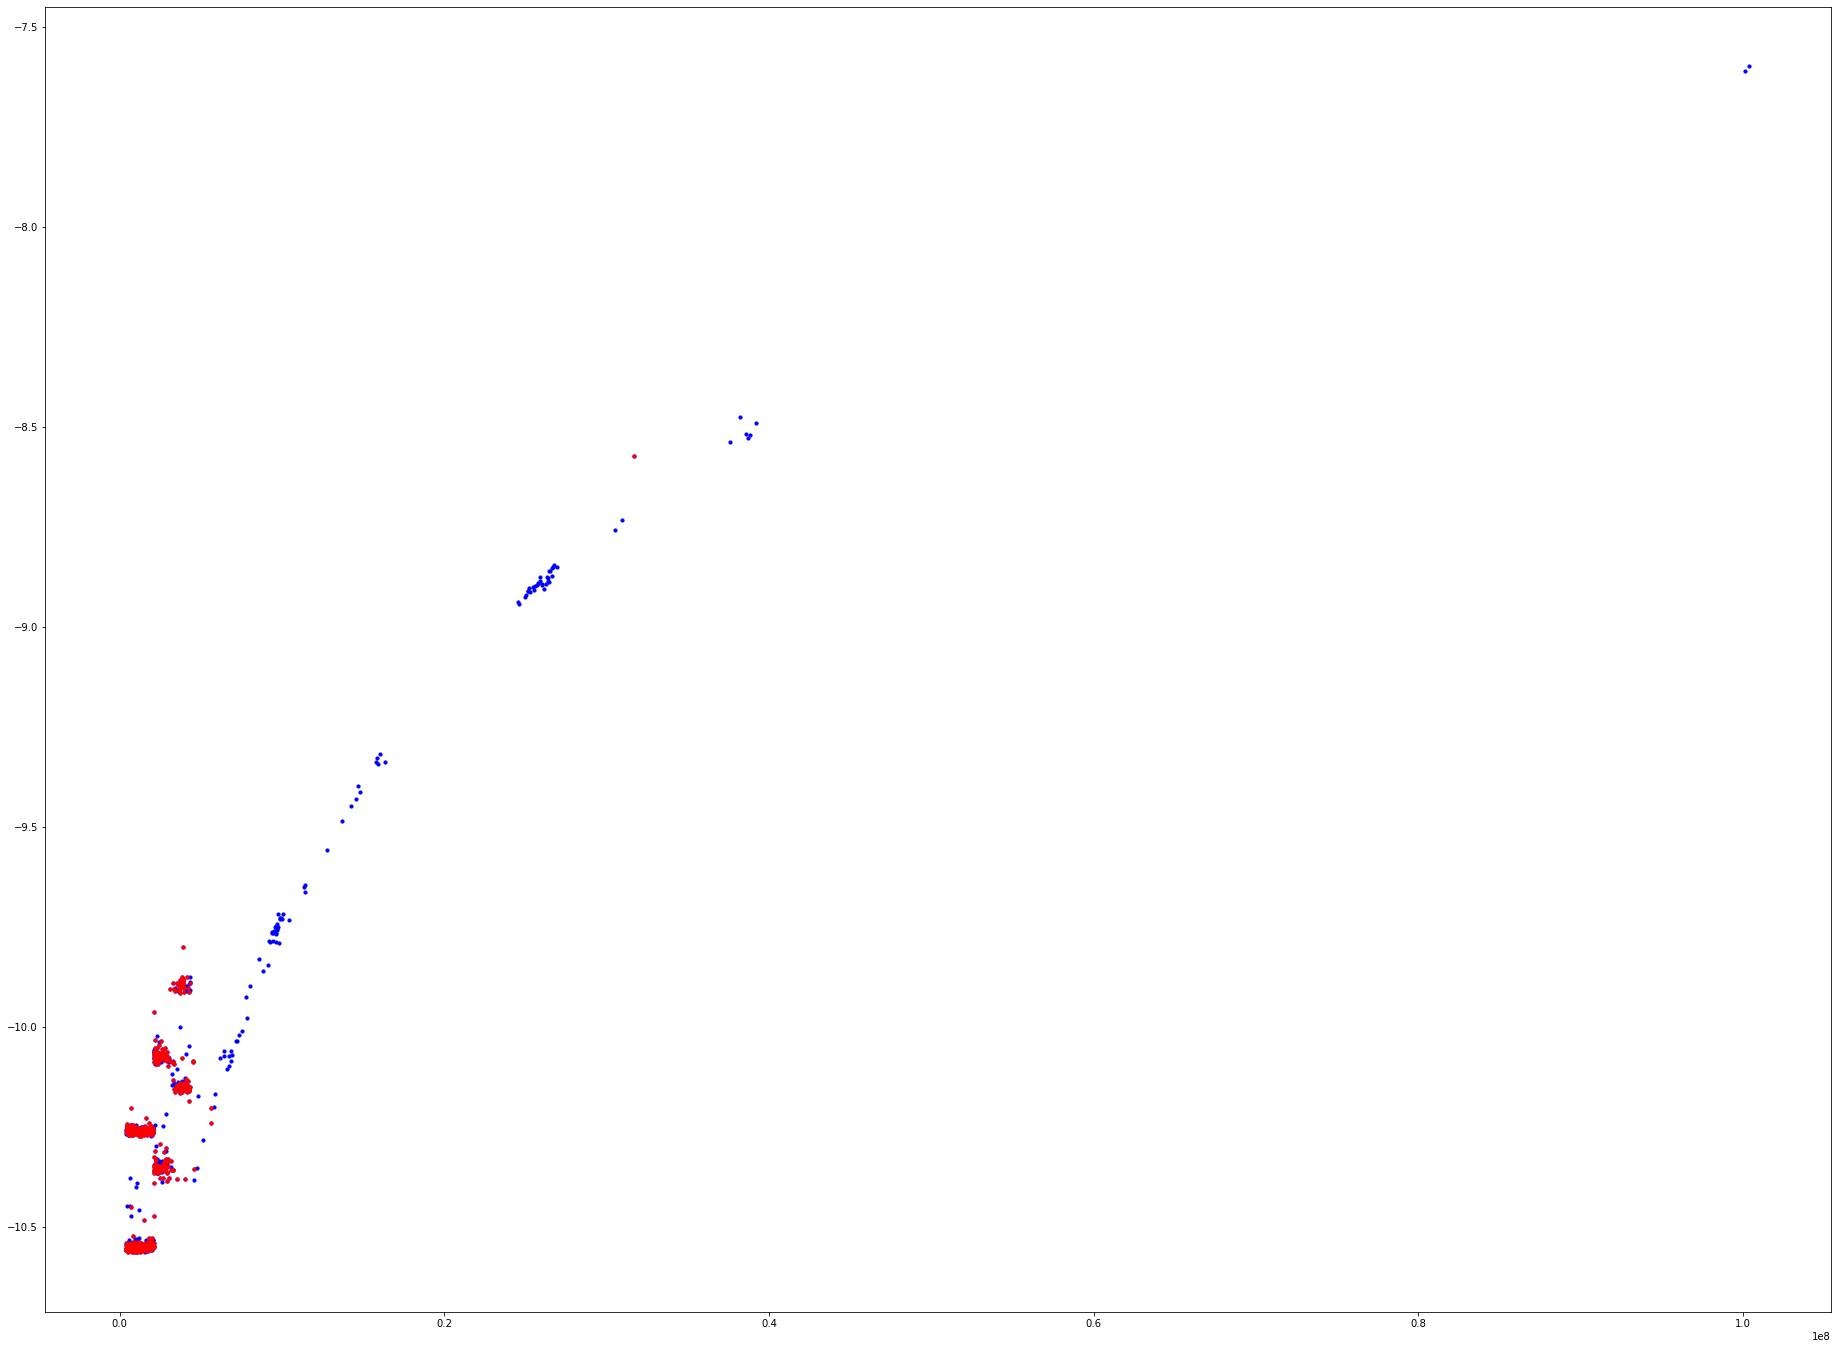

In [10]:
import matplotlib.pyplot as plt
import math

plt.figure(figsize=(32,24))
# plt.scatter([x[2] for x in trainx], [math.log(y) for y in trainy], color = 'blue', s = 10,label = 'train')
plt.scatter([x[2] for x in testx], [math.log(y) for y in testy], color = 'blue', s = 10, label = 'test')
plt.scatter([x[2] for x in errorx], [math.log(y) for y in errory], color = 'red', s = 10, label = 'test')

plt.show()

In [14]:
# finegrained sampling for data with error > 0.1
import random
def sample_in_range(mind, maxd, sample_num):
    '''sample #sample_num data from a range [mind, maxd)
    '''
    # if the sample_num is bigger than sample population, we only keep the number of population to avoid repetition
    if maxd - mind <= sample_num:
        data = list(range(mind, maxd))
        random.shuffle(data)
        return data
    else:
        return random.sample(range(mind, maxd), sample_num)


def sample_cin_cout(cin, cout, sample_num): 
    '''fine-grained sample #sample_num data in the cin and cout dimensions, respectively
    '''
    cins = sample_in_range(int(cin * 0.5), int(cin * 1.2), sample_num)
    couts = sample_in_range(int(cout * 0.5), int(cout * 1.2), sample_num)
    l = min(len(cins), len(couts)) # align the length of cins and couts
    cins, couts = cins[:l], couts[:l]
    return cins, couts


def finegrained_sampling_fc(cfgs, count):
    '''
    Sampling configs for fc kernels
    Returned params include: (cin, cout)
    '''
    ncfgs = []
    for cfg in cfgs:
        cins, couts = sample_cin_cout(cfg[0], cfg[1], count)
        for cin, cout in zip(cins, couts):
            c = {
                'in_features': cin,
                'out_features': cout
            }
            ncfgs.append(c)
    print("finegrained data: ", len(ncfgs))
    return ncfgs

with open("finegrained_data.json", "w") as fp:
    json.dump(finegrained_sampling_fc(errorx, 20), fp, indent=4)

finegrained data:  12380
